# Spaceship Titanic

**Problem Type:** Binary Classification

## Evaluation Metric


<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Import Libraries</h1>
</div>

In [1]:
import os
from pathlib import Path
import time
import gc

import random
import pandas as pd
import numpy as np
import datatable as dt  # Fast table loading

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Visualization Libraries
import matplotlib.pylab as plt
import seaborn as sns

In [2]:
# Black formatter https://black.readthedocs.io/en/stable/

! pip install nb-black > /dev/null

%load_ext lab_black

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Configuration</h1>
</div>

In [3]:
class Config:
    path = "../input/spaceship-titanic"
    gpu = True
    debug = False
    optimize = True
    n_optimize_trials = 5
    model_type = "xgb"  # (xgb, cat, lgbm, keras)
    model_name = "xgb1"
    competition = "Spaceship Titanic"
    seed = 42
    N_ESTIMATORS = 100  # 100, 300, 2000, 5000

    batch_size = 64
    epochs = 25
    N_FOLDS = 15  # 5,10,15
    SEED_LENGTH = 1  # 5,10

In [4]:
TARGET = "Transported"
TARGET_ENC = "target_num"

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Utilities</h1>
</div>

In [5]:
def create_folds(df, TARGET, n_folds=5, seed=42):
    print(f"TARGET={TARGET}, n_folds={n_folds}, seed={seed}")
    df["fold"] = -1

    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    # kf = GroupKFold(n_splits=Config.N_FOLDS)

    for fold, (train_idx, valid_idx) in enumerate(kf.split(df, df[TARGET])):
        df.loc[valid_idx, "fold"] = fold

    # df.to_csv(f"train_fold{num_folds}.csv", index=False)
    return df

In [6]:
def label_encoder(train, test, columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] = LabelEncoder().fit_transform(test[col])
    return train, test

In [7]:
def read_data(path):
    data_dir = Path(path)

    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")
    # train_df = dt.fread(data_dir / "train.csv").to_pandas()
    # test_df = dt.fread(data_dir / "test.csv").to_pandas()

    submission_df = pd.read_csv(data_dir / "sample_submission.csv")

    print(f"train data: Rows={train.shape[0]}, Columns={train.shape[1]}")
    print(f"test data : Rows={test.shape[0]}, Columns={test.shape[1]}")
    return train, test, submission_df

In [8]:
# OOF Results
if not os.path.exists("results"):
    os.makedirs("results")

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Load Train/Test Data</h1>
</div>

Support datatable for large datasets.
Using datatable is described in [Tutorial on reading datasets](https://www.kaggle.com/hiro5299834/tutorial-on-reading-datasets)

In [9]:
%%time
train, test, submission_df = read_data(Config.path)

train data: Rows=8693, Columns=14
test data : Rows=4277, Columns=13
CPU times: user 57.6 ms, sys: 11.3 ms, total: 68.8 ms
Wall time: 101 ms


In [10]:
train.sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
8037,8602_02,Earth,False,G/1396/P,PSO J318.5-22,21.0,NaN,10.0,1028.0,3.0,2519.0,0.0,Yvonna Weissey,False
5926,6285_02,Europa,False,B/245/S,TRAPPIST-1e,43.0,False,2.0,5329.0,0.0,7.0,0.0,Shail Whealeed,True
4843,5166_01,Mars,False,D/163/P,TRAPPIST-1e,32.0,False,382.0,0.0,477.0,22.0,2.0,Cor Porki,True
2656,2840_01,Earth,False,F/540/S,55 Cancri e,44.0,False,672.0,0.0,0.0,0.0,20.0,Jacky Hortis,False
7532,8054_01,Mars,False,F/1540/S,55 Cancri e,52.0,False,NaN,0.0,262.0,1425.0,571.0,Hex Reste,False


In [11]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [13]:
train[TARGET].unique()

array([False,  True])

In [14]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


In [15]:
train.describe(include=["float64"]).T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


In [16]:
# features with object and bool types
train.describe(include=[object, bool]).T

,count,unique,top,freq
PassengerId,8693,8693,0001_01,1
HomePlanet,8492,3,Earth,4602
CryoSleep,8476,2,False,5439
Cabin,8494,6560,G/734/S,8
Destination,8511,3,TRAPPIST-1e,5915
VIP,8490,2,False,8291
Name,8493,8473,Gollux Reedall,2
Transported,8693,2,True,4378


In [17]:
corr = train.corr()
corr.style.background_gradient(cmap="coolwarm")

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007,-0.075026
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.244611
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995,0.046566
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322,0.010141
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821,-0.221131
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.207075
Transported,-0.075026,-0.244611,0.046566,0.010141,-0.221131,-0.207075,1.000000


In [18]:
train[TARGET] = train[TARGET].replace({True: 1, False: 0})
train["VIP"] = train["VIP"].replace({True: 1, False: 0})  # .astype(int)
train["CryoSleep"] = train["CryoSleep"].replace({True: 1, False: 0})  # .astype(int)
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,0.0,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,0002_01,Earth,0.0,F/0/S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,0003_01,Europa,0.0,A/0/S,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0
3,0003_02,Europa,0.0,A/0/S,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0
4,0004_01,Earth,0.0,F/1/S,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   float64
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   float64
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   int64  
dtypes: float64(8), int64(1), object(5)
memory usage: 950.9+ KB


In [20]:
%%time
# sns.pairplot(train, hue="Transported", height=3, diag_kind="hist")
# # sns.pairplot(train, height=3, diag_kind="hist")
# plt.show()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 9.3 µs


<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Missing Values</h1>
</div>

In [21]:
print("=" * 5, "Missing Training Data", "=" * 5)
missing_vals = train.isna().sum()
print(missing_vals[missing_vals > 0])
print("=" * 5, "Missing Test Data", "=" * 5)
missing_vals = test.isna().sum()
print(missing_vals[missing_vals > 0])

===== Missing Training Data =====
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
dtype: int64
===== Missing Test Data =====
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


- https://www.kaggle.com/code/hamzaghanmi/let-s-use-keras-tensorflow

In [22]:
# Looking at NaN % within the train data
nan = pd.DataFrame(train.isna().sum(), columns=["NaN_sum"])
nan["Percentage(%)"] = (nan["NaN_sum"] / len(train)) * 100
nan = nan[nan["NaN_sum"] > 0]
nan = nan.sort_values(by=["NaN_sum"])
nan

,NaN_sum,Percentage(%)
Age,179,2.059128
RoomService,181,2.082135
Destination,182,2.093639
FoodCourt,183,2.105142
Spa,183,2.105142
VRDeck,188,2.162660
Cabin,199,2.289198
Name,200,2.300702
HomePlanet,201,2.312205
VIP,203,2.335212


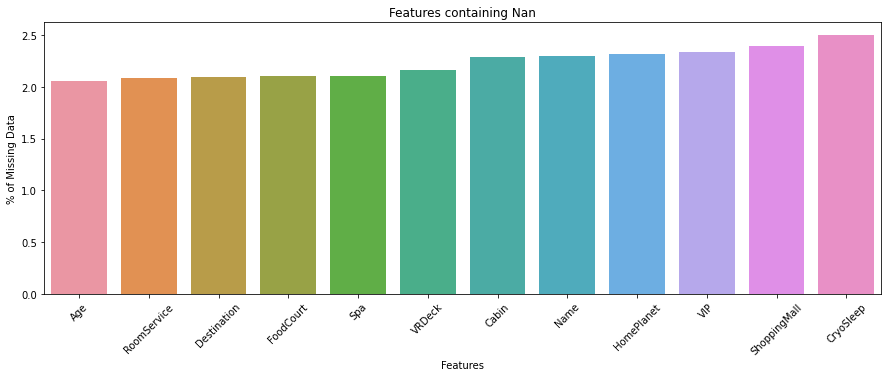

In [23]:
# Plotting Nan

plt.figure(figsize=(15, 5))
sns.barplot(x=nan.index, y=nan["Percentage(%)"])
plt.xticks(rotation=45)
plt.title("Features containing Nan")
plt.xlabel("Features")
plt.ylabel("% of Missing Data")
plt.show()

- https://www.kaggle.com/code/shilongzhuang/space-titanic-a-beginner-guide-80-24-accuracy

In [24]:
def missing_values(df):
    # Calculate missing value and their percentage for each feature
    missing_percent = df.isnull().sum() * 100 / df.shape[0]
    df_missing_percent = pd.DataFrame(missing_percent).round(2)
    df_missing_percent = df_missing_percent.reset_index().rename(
        columns={"index": "Feature", 0: "Missing Percentage (%)"}
    )
    df_missing_value = df.isnull().sum()
    df_missing_value = df_missing_value.reset_index().rename(
        columns={"index": "Feature", 0: "Missing Values"}
    )

    final = df_missing_value.merge(
        df_missing_percent, how="inner", left_on="Feature", right_on="Feature"
    )
    final = final.sort_values(by="Missing Percentage (%)", ascending=False)
    return final

In [25]:
missing_values(train)

,Feature,Missing Values,Missing Percentage (%)
2,CryoSleep,217,2.50
9,ShoppingMall,208,2.39
6,VIP,203,2.34
1,HomePlanet,201,2.31
12,Name,200,2.30
3,Cabin,199,2.29
11,VRDeck,188,2.16
8,FoodCourt,183,2.11
10,Spa,183,2.11
4,Destination,182,2.09


In [26]:
missing_values(test)

,Feature,Missing Values,Missing Percentage (%)
8,FoodCourt,106,2.48
10,Spa,101,2.36
3,Cabin,100,2.34
9,ShoppingMall,98,2.29
12,Name,94,2.20
2,CryoSleep,93,2.17
6,VIP,93,2.17
4,Destination,92,2.15
5,Age,91,2.13
1,HomePlanet,87,2.03


In [27]:
## Separate Categorical and Numerical Features
cat_features = list(train.select_dtypes(include=["category", "object"]).columns)
num_features = list(test.select_dtypes(include=["number"]).columns)

In [28]:
print(f"Categorical Features: {cat_features}")
print(f"Numerical Features: {num_features}")

Categorical Features: ['PassengerId', 'HomePlanet', 'Cabin', 'Destination', 'Name']
Numerical Features: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


In [29]:
# cat_col = [col for col in train.columns if train[col].nunique() < 4]
# cat_col

In [30]:
## Double check cardinality or numerical features.  Could be categorical features
cat_col = [col for col in num_features if train[col].nunique() < 25]
cat_col

[]